# Two Monopods on Skateboard
### Model a monopod to apply backfoot and frontfoot applied force on the skateboard


In [1]:
# import the script that holds a bunch of the re-used functions
import skaterlib_2
from importlib import reload
import cloudpickle

reload(skaterlib_2);

model = 'model_save_Neq60_2_monos_13_09_2019_10_58.pkl'
model = 'model_save_Neq60_2_monos_13_09_2019_12_17.pkl'
model = 'model_save_Neq60_2_monos_09_10_2019_18_27.pkl'
model = 'model_save_Neq60_2_monos_09_10_2019_18_58.pkl'
model = 'model_save_Neq60_2_monos_09_10_2019_21_56.pkl'

filepath = 'saved_models\\'
filename = filepath+model
with open(filename, mode='rb') as file:
    m_saved = cloudpickle.load(file)

In [2]:
# import libraries
import pickle as pkl
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# DERIVE EOMS OF BOARD --------------------------------------------------------------------------------------------------------

# system parameters
g = sym.symbols('g')
mb = sym.symbols('m_{board}') # mass
lb = sym.symbols('l_{board}') # length
lbr = sym.symbols('l_{wheels}') # length to reaction forces
hb = sym.symbols('h_{board}') # height - board clearance
Inb = sym.symbols('In_{board}') # moment of intertia
rF_FF, rF_BF = sym.symbols(['r_{F_{FF}}','r_{F_{BF}}']) # distance of feet from COM. 

# generalized coordinates
x,y,thb = sym.symbols(['x','y','\\theta_{board}']) 
dx,dy,dthb = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{board}']) 
ddx,ddy,ddthb = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{board}']) 

q = sym.Matrix([[x],[y],[thb]])
dq = sym.Matrix([[dx],[dy],[dthb]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb]])

# forces
GRF_BW,GRF_FW = sym.symbols(['GRF_{BW}','GRF_{FW}']) # ground reaction forces
F_BFx_sb,F_BFy_sb = sym.symbols(['F_{BFx_{sb}}','F_{BFy_{sb}}']) # back foot applied forces
F_FFx_sb,F_FFy_sb = sym.symbols(['F_{FFx_{sb}}','F_{FFy_{sb}}']) # front foot applied forces

# Unpickle stored EOMs
infile = open('skateboard_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs_board = data['EOMs_Fsb']

In [3]:
# Lambdify EOMs
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,lb,lbr,Inb,hb,
            x,y,thb,
            dx,dy,dthb,
            ddx,ddy,ddthb,
            rF_BF,rF_FF,
            F_BFx_sb,F_BFy_sb,F_FFx_sb,F_FFy_sb,
            GRF_BW,GRF_FW]
            
lambEOMx_board   = sym.lambdify(sym_list,EOMs_board[0],modules = [func_map])
lambEOMy_board   = sym.lambdify(sym_list,EOMs_board[1],modules = [func_map])
lambEOMth_board  = sym.lambdify(sym_list,EOMs_board[2],modules = [func_map])

In [4]:
# DERIVE EOMS OF MONOPOD --------------------------------------------------------------------------------------------------------

from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thl,r = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg}','r']) 
dx,dy,dthb,dthl,dr = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg}','\dot{r}']) 
ddx,ddy,ddthb,ddthl,ddr = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg}','\ddot{r}']) 

q = sym.Matrix([[x],[y],[thb],[thl],[r]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthl],[dr]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthl],[ddr]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
F,tau,GRFx,GRFy = sym.symbols(['F','\\tau','G_x','G_y']) 

# Unpickle stored EOMs
infile = open('monopod_EOMs','rb')
data = pkl.load(infile)
infile.close()

EOMs_monopod = data['EOMs']

In [5]:
# Lambdify EOMs of Monopod
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thl,r,
            dx,dy,dthb,dthl,dr,
            ddx,ddy,ddthb,ddthl,ddr,
            F,tau,GRFx,GRFy]
            
lambEOMxb_monopod = sym.lambdify(sym_list,EOMs_monopod[0],modules = [func_map])
lambEOMyb_monopod = sym.lambdify(sym_list,EOMs_monopod[1],modules = [func_map])
lambEOMthb_monopod = sym.lambdify(sym_list,EOMs_monopod[2],modules = [func_map])
lambEOMthl_monopod = sym.lambdify(sym_list,EOMs_monopod[3],modules = [func_map])
lambEOMr_monopod = sym.lambdify(sym_list,EOMs_monopod[4],modules = [func_map])

In [6]:
# Unpickle foot position and velocity

xm,ym,thm,thl,r = sym.symbols(['x_{mono}','y_{mono}','\\theta_{mono}','\\theta_{link1}','r_{mono}']) # monopod in global frame
dxm,dym,dthm,dthl,dr = sym.symbols(['\dot{x}_{mono}','\dot{y}_{mono}','\dot{\\theta}_{mono}','\dot{\\theta}_{link1}','\dot{r}_{mono}'])
l1,l2 = sym.symbols(['l_{link1}','l_{link2}']) # lenghts of links
xb,yb,thb = sym.symbols(['x_{board}','y_{board}','\\theta_{board}']) # board in global frame
dxb,dyb,dthb = sym.symbols(['\dot{x}_{board}','\dot{y}_{board}','\dot{\\theta}_{board}'])

# Unpickle stored EOMs
infile = open('monopod_EOMs','rb')
data = pkl.load(infile)
infile.close()

pfoot = data['pfoot']
pfoot_board = data['pfoot_board']
vfootx_board = data['vfootx_board']

# Lambdify pfoot_board
func_map = {'sin':sin, 'cos':cos, 'atan':atan} 
sym_list = [l1, l2, xb, yb, thb, xm, ym, thm, thl, r]
sym_list2 = [l1, l2, xb, yb, thb, xm, ym, thm, thl, r, dxb, dyb, dthb, dxm, dym, dthm, dthl, dr]

lambfootx = sym.lambdify(sym_list,pfoot[0],modules = [func_map])
lambfooty = sym.lambdify(sym_list,pfoot[1],modules = [func_map])
lambfootx_board = sym.lambdify(sym_list,pfoot_board[0],modules = [func_map])
lambfooty_board = sym.lambdify(sym_list,pfoot_board[1],modules = [func_map])
lambvfootx_board = sym.lambdify(sym_list2,vfootx_board,modules = [func_map])

In [7]:
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 60
N1 = 16
N2 = 50
m.N = RangeSet(N)

DOFs = ['x','y','th','xb','yb','thb','thl','r','xb2','yb2','thb2','thl2','r2'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

Fs = ['BF','FF'] # front foot, backfoot
m.Fs = Set(initialize = Fs) 

GRFs = ['BW','FW'] # front wheel, back wheel
m.GRFs = Set(initialize = GRFs) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

WDOFs = ['X','Y'] # absolute coordinates
m.WDOF = Set(initialize = WDOFs)

DOF_b = ['x_b','y_b'] # coordinates in skateboard frame
m.DOF_b = Set(initialize = DOF_b)

DOF_m = ['x_m','y_m'] # coordinates in monopod frame
m.DOF_m = Set(initialize = DOF_m)

bodies = ['board','mono1','mono2'] 
m.bodies = Set(initialize = bodies)

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

# general
m.g = Param(initialize = 9.81) # gravity

# board
m.mbd = Param(initialize = 2.0) # mass of board
m.lbd = Param(initialize = 0.80) # length of board
m.lbrd = Param(initialize = 0.45) # length between wheels lb-(14.3+3)*2
m.hbd = Param(initialize = 0.09) # board clearance
m.etail = Param(initialize = -0.6) #coefficient of restitution of tail
m.Inbd = Param(initialize = 1/12*m.mbd*m.lbd**2) # moment of inertia about centre

BW_sb = m.mbd*m.g

# monopod
def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    return 1/12*m.m[l]*m.len[l]**2 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

m_monopod = sum(m.m[l] for l in links)
BW = 2*m_monopod*m.g

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# applied and ground reaction forces and torques
# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

m.Fb_b = Var(m.N, m.Fs, m.DOF_b, m.sgn, bounds = (0.0,20.0)) # Forces from front and back feet, board frame
m.Fb_b_total = Var(m.N, m.Fs, m.DOF_b)
m.GRF = Var(m.N, m.GRFs, bounds = (0.0, 20.0)) # Ground reaction force on back wheel
m.GRFbf = Var(m.N, m.Fs, m.WDOF) # Board reaction force on foot, global frame
m.tau_a = Var(m.N, m.bodies, bounds = (-1,1)) # actuator torque at hip
m.F_a = Var(m.N, m.bodies, bounds = (-5,5)) # actuator force at knee
m.F_r = Var(m.N, m.bodies, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

# AUXILIARY VARIABLES

# skateboard
m.ptail = Var(m.N, m.WDOF) # back of board
m.pnose = Var(m.N, m.WDOF) # front of board
m.pwheel = Var(m.N, m.GRFs, m.WDOF) # position of wheels
m.vtail = Var(m.N, m.WDOF) # velocity of back of board

def def_ptail(m,n,dof):
    if dof == 'X':
        return m.ptail[n, 'X'] == m.q[n,'x'] - 0.5*m.lbd*cos(m.q[n,'th'])
    if dof == 'Y':
        return m.ptail[n, 'Y'] == m.q[n,'y'] - 0.5*m.lbd*sin(m.q[n,'th']) 
    else:
        return Constraint.Skip
m.def_ptail = Constraint(m.N, m.WDOF,rule = def_ptail)

def def_pnose(m,n,dof):
    if dof == 'X':
        return m.pnose[n, 'X'] == m.q[n,'x'] + 0.5*m.lbd*cos(m.q[n,'th'])
    if dof == 'Y':
        return m.pnose[n, 'Y'] == m.q[n,'y'] + 0.5*m.lbd*sin(m.q[n,'th']) 
    else:
        return Constraint.Skip
m.def_pnose = Constraint(m.N, m.WDOF,rule = def_pnose)

def def_pwheels(m,n,wheel,dof):
    if wheel == 'BW':
        if dof == 'X':
            return m.pwheel[n,'BW','X'] == m.q[n,'x']-0.5*m.lbrd*cos(m.q[n,'th'])+m.hbd*sin(m.q[n,'th'])
        if dof == 'Y':
            return m.pwheel[n,'BW','Y'] == m.q[n,'y']-0.5*m.lbrd*sin(m.q[n,'th'])-m.hbd*cos(m.q[n,'th'])
        else:
            return Constraint.Skip
    if wheel == "FW":
        if dof == 'X':
            return m.pwheel[n,'FW','X'] == m.q[n,'x']+0.5*m.lbrd*cos(m.q[n,'th'])+m.hbd*sin(m.q[n,'th'])
        if dof == 'Y':
            return m.pwheel[n,'FW','Y'] == m.q[n,'y']+0.5*m.lbrd*sin(m.q[n,'th'])-m.hbd*cos(m.q[n,'th'])
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_pwheels = Constraint(m.N, m.GRFs, m.WDOF,rule = def_pwheels)

def def_vtail(m,n,dof):
    if dof == 'Y':
        return m.vtail[n, 'Y'] == m.dq[n,'y']-m.dq[n,'th']*0.5*m.lbd*cos(m.q[n,'th'])
    else:
        return Constraint.Skip
m.def_vtail = Constraint(m.N, m.WDOF,rule = def_vtail)

# skateboard - bound variables
for n in range(1,N+1):
    m.pnose[n,'Y'].setlb(0.0)
    m.ptail[n,'Y'].setlb(0.0)
    m.pwheel[n,'BW','Y'].setlb(0.0)
    m.pwheel[n,'FW','Y'].setlb(0.0)
    m.q[n,'th'].setub(np.pi/2)
    m.q[n,'th'].setlb(-np.pi/2)
    
# monopod - bound variables
for n in range(1,N+1):  
    m.q[n,'thb'].setlb(-np.pi/2)
    m.q[n,'thb'].setub(np.pi/2)
    m.q[n,'thl'].setlb(-np.pi/2)
    m.q[n,'thl'].setub(np.pi/2)
    m.q[n,'thb2'].setlb(-np.pi/2)
    m.q[n,'thb2'].setub(np.pi/2)
    m.q[n,'thl2'].setlb(-np.pi/2)
    m.q[n,'thl2'].setub(np.pi/2)
    #m.GRFbf[n,'Y'].setlb(0.0)
    
# monopod 
m.pfoot = Var(m.N, m.Fs, m.WDOF) # foot position
m.pfoot_b = Var(m.N, m.Fs, m.DOF_b) # foot position in skateboard frame
m.vfoot_b = Var(m.N, m.Fs, m.DOF_b, m.sgn, bounds = (0.0,None)) # foot velocity
m.friction_cone = Var(m.N, m.Fs, bounds = (0.0,None))

for n in range(1,N+1):  
    m.pfoot[n,'BF','Y'].setlb(0.0)
    m.pfoot_b[n,'BF','y_b'].setlb(0.0)
    m.pfoot_b[n,'BF','x_b'].setub(0.0)
    m.pfoot_b[n,'BF','x_b'].setlb(-0.5*m.lbd)
    m.pfoot[n,'FF','Y'].setlb(0.0)
    m.pfoot_b[n,'FF','y_b'].setlb(0.0)
    m.pfoot_b[n,'FF','x_b'].setlb(0.0)
    m.pfoot_b[n,'FF','x_b'].setub(0.5*m.lbd)

def def_pfoot(m,n,fs,dof):
    # world frame
    if fs == 'BF':
        var_list = [m.len[('leg',1)],m.len[('leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xb'], m.q[n,'yb'], m.q[n,'thb'], m.q[n,'thl'], m.q[n,'r']]
        if dof == 'X':
            return m.pfoot[n,'BF','X'] == lambfootx(*var_list)
        if dof == 'Y':
            return m.pfoot[n,'BF','Y'] == lambfooty(*var_list)
        else:
            return Constraint.Skip
    if fs == 'FF':
        var_list = [m.len[('leg',1)],m.len[('leg',2)],
                        m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xb2'], m.q[n,'yb2'], m.q[n,'thb2'], m.q[n,'thl2'], m.q[n,'r2']]
        if dof == 'X':
            return m.pfoot[n,'FF','X'] == lambfootx(*var_list)
        if dof == 'Y':
            return m.pfoot[n,'FF','Y'] == lambfooty(*var_list)
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_pfoot = Constraint(m.N, m.Fs, m.WDOF, rule = def_pfoot)    
    
def def_pfoot_b(m,n,fs,dof): # board frame
    if fs == 'BF':
        var_list = [m.len[('leg',1)],m.len[('leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xb'], m.q[n,'yb'], m.q[n,'thb'], m.q[n,'thl'], m.q[n,'r']]
        if dof == 'x_b':
            return m.pfoot_b[n,'BF','x_b'] == lambfootx_board(*var_list)
        if dof == 'y_b':
            return m.pfoot_b[n,'BF','y_b'] == lambfooty_board(*var_list)
        else:
            return Constraint.Skip
    if fs == 'FF':
        var_list = [m.len[('leg',1)],m.len[('leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xb2'], m.q[n,'yb2'], m.q[n,'thb2'], m.q[n,'thl2'], m.q[n,'r2']]
        if dof == 'x_b':
            return m.pfoot_b[n,'FF','x_b'] == lambfootx_board(*var_list)
        if dof == 'y_b':
            return m.pfoot_b[n,'FF','y_b'] == lambfooty_board(*var_list)
        else:
            return Constraint.Skip
m.def_pfoot_b = Constraint(m.N, m.Fs, m.DOF_b, rule = def_pfoot_b)      

def def_vfoot_b(m,n,fs,dof): # board frame
    if fs == 'BF':
        var_list = [m.len[('leg',1)],m.len[('leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xb'], m.q[n,'yb'], m.q[n,'thb'], m.q[n,'thl'], m.q[n,'r'],
                    m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.dq[n,'xb'], m.dq[n,'yb'], m.dq[n,'thb'], m.dq[n,'thl'], m.dq[n,'r']]
        if dof == 'x_b':
            return m.vfoot_b[n,'BF','x_b','ps'] - m.vfoot_b[n,'BF','x_b','ng'] == lambvfootx_board(*var_list)
        else:
            return Constraint.Skip
    if fs == 'FF':
        var_list = [m.len[('leg',1)],m.len[('leg',2)],
                    m.q[n,'x'], m.q[n,'y'], m.q[n,'th'], m.q[n,'xb2'], m.q[n,'yb2'], m.q[n,'thb2'], m.q[n,'thl2'], m.q[n,'r2'],
                    m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.dq[n,'xb2'], m.dq[n,'yb2'], m.dq[n,'thb2'], m.dq[n,'thl2'], m.dq[n,'r2']]
        if dof == 'x_b':
            return m.vfoot_b[n,'FF','x_b','ps'] - m.vfoot_b[n,'FF','x_b','ng'] == lambvfootx_board(*var_list)
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_vfoot_b = Constraint(m.N, m.Fs, m.DOF_b, rule = def_vfoot_b)

def def_Fb_b_total(m,n,fs,dof):
    if fs == 'BF':
        if dof == 'x_b':
            return m.Fb_b_total[n,'BF','x_b'] == m.Fb_b[n,'BF','x_b','ps']-m.Fb_b[n,'BF','x_b','ng']
        if dof == 'y_b':
            return m.Fb_b_total[n,'BF','y_b'] == m.Fb_b[n,'BF','y_b','ps']
        else:
            return Constraint.Skip
    if fs == 'FF':
        if dof == 'x_b':
            return m.Fb_b_total[n,'FF','x_b'] == m.Fb_b[n,'FF','x_b','ps']-m.Fb_b[n,'FF','x_b','ng']
        if dof == 'y_b':
            return m.Fb_b_total[n,'FF','y_b'] == m.Fb_b[n,'FF','y_b','ps']
    else:
        return Constraint.Skip
m.def_Fb_b_total = Constraint(m.N, m.Fs, m.DOF_b, rule = def_Fb_b_total) 

# Constraints for foot and board contact --------------------------------------------------------------------------------------

m.rF = Var(m.N, m.Fs) # distance to applied force

def def_rF(m,n,fs): # contact point on board
    if fs == 'BF':
        return m.rF[n,'BF'] == -m.pfoot_b[n,'BF','x_b']
    if fs == 'FF':
        return m.rF[n,'FF'] == m.pfoot_b[n,'FF','x_b']
    else:
        return Constraint.Skip
m.def_rF = Constraint(m.N, m.Fs, rule = def_rF)

In [8]:
# m.rF.pprint()
# BW

In [9]:
# TIME AND INTEGRATION --------------------------------------------------------------------------------------------------------

# variable timestep
hm  = 0.01 #master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        if n==N1 and dof == 'y':
            return m.dq[n,'y'] == m.etail*m.vtail[n-1,'Y'] + m.dq[n-1,'y'] + hm*m.h[n]*m.ddq[n-1,'y'] #switching constraint at impact of tail and ground
        else:    
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

m.h[1].fix(0.0) # fix un-used time step

In [10]:
# AUXILIARY TO RESOLVE FOOT AND BOARD FORCES
# The back and front foot applied forces on the board, and the applied force of the monopod are in their own frames
# Need to transform them into the global frame.

m.F = Var(m.N, m.bodies, m.Fs, m.WDOF) # Forces, global frame
m.thA = Var(m.N, m.bodies) # absolute angle of monopod

def def_thA(m,n,body):
    if body == 'mono1':
        return m.thA[n, 'mono1'] == m.q[n,'thb'] + m.q[n,'thl']
    if body == 'mono2':
        return m.thA[n, 'mono2'] == m.q[n,'thb2'] + m.q[n,'thl2']
    else:
        return Constraint.Skip
m.def_thA = Constraint(m.N, m.bodies, rule = def_thA)

def def_F(m,n,body,fs,dof):
    if fs == 'BF':
        if body == 'mono1':
            if dof == 'X':
                return m.F[n,'mono1','BF','X'] == m.GRFbf[n,'BF','X']
            if dof == 'Y':
                return m.F[n,'mono1','BF','Y'] == m.GRFbf[n,'BF','Y']
            else:
                return Constraint.Skip
        if body == 'board':
            if dof == 'X':
                return m.F[n,'board','BF','X'] == m.Fb_b_total[n,'BF','x_b']*cos(m.q[n,'th']) + m.Fb_b_total[n,'BF','y_b']*sin(m.q[n,'th'])
            if dof == 'Y':
                return m.F[n,'board','BF','Y'] == m.Fb_b_total[n,'BF','x_b']*sin(m.q[n,'th']) - m.Fb_b_total[n,'BF','y_b']*cos(m.q[n,'th'])
            else:
                return Constraint.Skip
        else:
            return Constraint.Skip
    if fs == 'FF':
        if body == 'mono2':
            if dof == 'X':
                return m.F[n,'mono2','FF','X'] == m.GRFbf[n,'FF','X']
            if dof == 'Y':
                return m.F[n,'mono2','FF','Y'] == m.GRFbf[n,'FF','Y'] 
            else:
                return Constraint.Skip
        if body == 'board':
            if dof == 'X':
                return m.F[n,'board','FF','X'] == m.Fb_b_total[n,'FF','x_b']*cos(m.q[n,'th']) + m.Fb_b_total[n,'FF','y_b']*sin(m.q[n,'th'])
            if dof == 'Y':
                return m.F[n,'board','FF','Y'] == m.Fb_b_total[n,'FF','x_b']*sin(m.q[n,'th']) - m.Fb_b_total[n,'FF','y_b']*cos(m.q[n,'th'])
            else:
                return Constraint.Skip
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_F = Constraint(m.N, m.bodies, m.Fs, m.WDOF, rule = def_F)

def def_contact_forces(m,n,fs,dof): # resolve into X and Y - global frame
    if fs == 'BF':
        if dof == 'X':
            return m.F[n,'mono1','BF','X'] == -m.F[n,'board','BF','X']
        if dof == 'Y':
            return m.F[n,'mono1','BF','Y'] == -m.F[n,'board','BF','Y']
        else:
            return Constraint.Skip
    if fs == 'FF':
        if dof == 'X':
            return m.F[n,'mono2','FF','X'] == -m.F[n,'board','FF','X']
        if dof == 'Y':
            return m.F[n,'mono2','FF','Y'] == -m.F[n,'board','FF','Y']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.def_contact_forces = Constraint(m.N, m.Fs, m.WDOF, rule = def_contact_forces)

In [11]:
# -----------------------------------------------------------------------------------------------------------------------------
# Contact Forces
# -----------------------------------------------------------------------------------------------------------------------------
# paramters
m.mu = Param(initialize = 1) # friction coefficient

ground_constraints = ['contact_BW','contact_FW']
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

contact_constraints = ['contact_Fy', 'friction','slip_x_ps','slip_x_ng','foot_velocity']
m.contact_constraints = Set(initialize = contact_constraints) # set for indexing ground-related penalties
m.contact_penalty = Var(m.N, m.Fs, m.contact_constraints, bounds = (0.0,None))

# ground contact complemetarity  
def ground_contact(m,n,gc):
    if n < N:
        if gc == 'contact_FW':
            return m.ground_penalty[n,'contact_FW'] == m.pwheel[n+1,'FW','Y']*m.GRF[n,'FW'] 
        if gc == 'contact_BW':
            return m.ground_penalty[n,'contact_BW'] == m.pwheel[n+1,'BW','Y']*m.GRF[n,'BW']
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, m.ground_constraints, rule = ground_contact)

# foot on board contact complemetarity  
def foot_board_contact(m,n,fs,cc):
    if n < N:
        if fs == 'BF':
            if cc == 'contact_Fy':
                return m.contact_penalty[n,'BF','contact_Fy'] == m.pfoot_b[n+1,'BF','y_b']*m.Fb_b[n,'BF','y_b','ps']
            else:
                return Constraint.Skip
        if fs == 'FF':
            if cc == 'contact_Fy':
                return m.contact_penalty[n,'FF','contact_Fy'] == m.pfoot_b[n+1,'FF','y_b']*m.Fb_b[n,'FF','y_b','ps']
            else:
                return Constraint.Skip
        else:
            return Constraint.Skip
    else:
        return Constraint.Skip
m.foot_board_contact = Constraint(m.N, m.Fs, m.contact_constraints, rule = foot_board_contact)

# Friction
def def_friction_cone(m,n,fs):
    if fs == 'BF':
        return m.friction_cone[n,'BF'] == m.mu*m.Fb_b[n,'BF','y_b','ps'] - (m.Fb_b[n,'BF','x_b','ps']+m.Fb_b[n,'BF','x_b','ng'])
    if fs == 'FF':
        return m.friction_cone[n,'FF'] == m.mu*m.Fb_b[n,'FF','y_b','ps'] - (m.Fb_b[n,'FF','x_b','ps']+m.Fb_b[n,'FF','x_b','ng'])
    else:
        return Constraint.Skip
m.def_friction_cone = Constraint(m.N, m.Fs, rule = def_friction_cone)

def board_friction(m,n,fs): # the foot can't move if not over max static friction, or no normal force.
    if fs == 'BF':
        return m.contact_penalty[n,'BF','friction'] == (m.vfoot_b[n,'BF','x_b','ps']+m.vfoot_b[n,'BF','x_b','ng'])*m.friction_cone[n,'BF']
    if fs == 'FF':
        return m.contact_penalty[n,'FF','friction'] == (m.vfoot_b[n,'FF','x_b','ps']+m.vfoot_b[n,'FF','x_b','ng'])*m.friction_cone[n,'FF']
    else:
        return Constraint.Skip
m.board_friction = Constraint(m.N, m.Fs, rule = board_friction)

# slipping
def board_slip_ps(m,n,fs): # the friction force must be applied in opposite direction to velocity of foot.
    if fs == 'BF':
        return m.contact_penalty[n,'BF','slip_x_ps'] == m.vfoot_b[n,'BF','x_b','ps']*m.Fb_b[n,'BF','x_b','ng']
    if fs == 'FF':
        return m.contact_penalty[n,'FF','slip_x_ps'] == m.vfoot_b[n,'FF','x_b','ps']*m.Fb_b[n,'FF','x_b','ng']
    else:
        return Constraint.Skip
m.board_slip_ps = Constraint(m.N, m.Fs, rule = board_slip_ps)

def board_slip_ng(m,n,fs): # the friction force must be applied in opposite direction to velocity of foot.
    if fs == 'BF':
        return m.contact_penalty[n,'BF','slip_x_ng'] == m.vfoot_b[n,'BF','x_b','ng']*m.Fb_b[n,'BF','x_b','ps']
    if fs == 'FF':
        return m.contact_penalty[n,'FF','slip_x_ng'] == m.vfoot_b[n,'FF','x_b','ng']*m.Fb_b[n,'FF','x_b','ps']
    else:
        return Constraint.Skip
m.board_slip_ng = Constraint(m.N, m.Fs, rule = board_slip_ng)

# foot velocity - only vf+ or vf- must be non-zero, not both.
def vfoot_b_penalty(m,n,fs):
    if fs == 'BF':
        return m.contact_penalty[n,'BF','foot_velocity'] == m.vfoot_b[n,'BF','x_b','ps']*m.vfoot_b[n,'BF','x_b','ng']
    if fs == 'FF':
        return m.contact_penalty[n,'FF','foot_velocity'] == m.vfoot_b[n,'FF','x_b','ps']*m.vfoot_b[n,'FF','x_b','ng']
    else:
        return Constraint.Skip
m.vfoot_b_penalty = Constraint(m.N, m.Fs, rule = vfoot_b_penalty)

for grf in GRFs:
    m.GRF[N, grf].fix(0.0)
for fs in Fs:
    for dof in DOF_b:
        for sgn in signs:
            m.Fb_b[N, fs, dof, sgn].fix(0.0)
    for cc in contact_constraints:
        m.contact_penalty[N, fs, cc].fix(0.0)
for gnd in ground_constraints:
    m.ground_penalty[N, gnd].fix(0.0)


In [12]:
# Reaction force at knee

# sets
joints = ['knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

knee_bound = [0.0,0.5]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'r'].setlb(knee_bound[0])
    m.q[n,'r'].setub(knee_bound[1])
    m.q[n,'r2'].setlb(knee_bound[0])
    m.q[n,'r2'].setub(knee_bound[1])
    
m.joint_penalty = Var(m.N, m.bodies, m.J, m.joint_constraints, bounds = (0.0,None))

def knee_limits(m,n,body,jc):
    if n < N:
        if body == 'mono1':
            if jc == 'up':
                # NEXT distance
                return m.joint_penalty[n,'mono1','knee',jc] == (m.knee_bound['up'] - m.q[n+1,'r'])*m.F_r[n,'mono1','ng']
            else: # jc =='low'
                return m.joint_penalty[n,'mono1','knee',jc] == (m.q[n+1,'r'] - m.knee_bound['lo'])*m.F_r[n,'mono1','ps']
        if body == 'mono2':
            if jc == 'up':
                # NEXT distance
                return m.joint_penalty[n,'mono2','knee',jc] == (m.knee_bound['up'] - m.q[n+1,'r2'])*m.F_r[n,'mono2','ng']
            else: # jc =='low'
                return m.joint_penalty[n,'mono2','knee',jc] == (m.q[n+1,'r2'] - m.knee_bound['lo'])*m.F_r[n,'mono2','ps']
        else: 
            return Constraint.Skip
    else:
        return Constraint.Skip
m.knee_limits = Constraint(m.N, m.bodies, m.joint_constraints, rule = knee_limits)

# bound contact forces at last node
for sgn in signs:
    for body in bodies:
        m.F_r[N,body,sgn].fix(0.0)
    
for jc in joint_constraints:
    for body in bodies:
        for j in joints:
            m.joint_penalty[N,body,j,jc].fix(0.0)

In [13]:
# -----------------------------------------------------------------------------------------------------------------------------
# EOMs 
# -----------------------------------------------------------------------------------------------------------------------------

# EOMs of skateboard
def EOMx_board(m,n):
    BFx_in = BW*m.Fb_b_total[n,'BF','x_b']
    BFy_in = BW*m.Fb_b_total[n,'BF','y_b']
    FFx_in = BW*m.Fb_b_total[n,'FF','x_b']
    FFy_in = BW*m.Fb_b_total[n,'FF','y_b']
    GBW_in = BW*m.GRF[n,'BW']
    GFW_in = BW*m.GRF[n,'FW']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mbd, m.lbd, m.lbrd, m.Inbd, m.hbd, m.q[n,'x'], m.q[n,'y'], m.q[n,'th'],
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'th'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               BFx_in, BFy_in, FFx_in, FFy_in, 
               GBW_in, GFW_in]
    return lambEOMx_board(*var_list) == 0
m.EOMx_board = Constraint(m.N, rule = EOMx_board)

def EOMy_board(m,n):
    BFx_in = BW*m.Fb_b_total[n,'BF','x_b']
    BFy_in = BW*m.Fb_b_total[n,'BF','y_b']
    FFx_in = BW*m.Fb_b_total[n,'FF','x_b']
    FFy_in = BW*m.Fb_b_total[n,'FF','y_b']
    GBW_in = BW*m.GRF[n,'BW']
    GFW_in = BW*m.GRF[n,'FW']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mbd, m.lbd, m.lbrd, m.Inbd, m.hbd, m.q[n,'x'], m.q[n,'y'], m.q[n,'th'],
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'th'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               BFx_in, BFy_in, FFx_in, FFy_in, 
               GBW_in, GFW_in]
    return lambEOMy_board(*var_list) == 0
m.EOMy_board = Constraint(m.N, rule = EOMy_board)

def EOMth_board(m,n):
    BFx_in = BW*m.Fb_b_total[n,'BF','x_b']
    BFy_in = BW*m.Fb_b_total[n,'BF','y_b']
    FFx_in = BW*m.Fb_b_total[n,'FF','x_b']
    FFy_in = BW*m.Fb_b_total[n,'FF','y_b']
    GBW_in = BW*m.GRF[n,'BW']
    GFW_in = BW*m.GRF[n,'FW']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g, m.mbd, m.lbd, m.lbrd, m.Inbd, m.hbd, m.q[n,'x'], m.q[n,'y'], m.q[n,'th'],
               m.dq[n,'x'], m.dq[n,'y'], m.dq[n,'th'], m.ddq[n,'x'], m.ddq[n,'y'], m.ddq[n,'th'],
               m.rF[n,'BF'], m.rF[n,'FF'],
               BFx_in, BFy_in, FFx_in, FFy_in, 
               GBW_in, GFW_in]
    return lambEOMth_board(*var_list) == 0
m.EOMth_board = Constraint(m.N, rule = EOMth_board)

# EOMs of monopod 1
def EOMxb_monopod(m,n):
    GRFx_in = BW*m.GRFbf[n,'BF','X']
    GRFy_in = BW*m.GRFbf[n,'BF','Y']
    F_a_in = BW*(m.F_a[n,'mono1'] + m.F_r[n,'mono1','ps'] - m.F_r[n,'mono1','ng'])
    tau_a_in = BW*m.tau_a[n,'mono1']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMxb_monopod(*var_list) == 0
m.EOMxb_monopod = Constraint(m.N, rule = EOMxb_monopod)

def EOMyb_monopod(m,n):
    GRFx_in = BW*m.GRFbf[n,'BF','X']
    GRFy_in = BW*m.GRFbf[n,'BF','Y']
    F_a_in = BW*(m.F_a[n,'mono1'] + m.F_r[n,'mono1','ps'] - m.F_r[n,'mono1','ng'])
    tau_a_in = BW*m.tau_a[n,'mono1']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMyb_monopod(*var_list) == 0
m.EOMyb_monopod = Constraint(m.N, rule = EOMyb_monopod)

def EOMthb_monopod(m,n):
    GRFx_in = BW*m.GRFbf[n,'BF','X']
    GRFy_in = BW*m.GRFbf[n,'BF','Y']
    F_a_in = BW*(m.F_a[n,'mono1'] + m.F_r[n,'mono1','ps'] - m.F_r[n,'mono1','ng'])
    tau_a_in = BW*m.tau_a[n,'mono1']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMthb_monopod(*var_list) == 0
m.EOMthb_monopod = Constraint(m.N, rule = EOMthb_monopod)

def EOMthl_monopod(m,n):
    GRFx_in = BW*m.GRFbf[n,'BF','X']
    GRFy_in = BW*m.GRFbf[n,'BF','Y']
    F_a_in = BW*(m.F_a[n,'mono1'] + m.F_r[n,'mono1','ps'] - m.F_r[n,'mono1','ng'])
    tau_a_in = BW*m.tau_a[n,'mono1']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMthl_monopod(*var_list) == 0
m.EOMthl_monopod = Constraint(m.N, rule = EOMthl_monopod)

def EOMr_monopod(m,n):
    GRFx_in = BW*m.GRFbf[n,'BF','X']
    GRFy_in = BW*m.GRFbf[n,'BF','Y']
    F_a_in = BW*(m.F_a[n,'mono1'] + m.F_r[n,'mono1','ps'] - m.F_r[n,'mono1','ng'])
    tau_a_in = BW*m.tau_a[n,'mono1']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb'],m.q[n,'yb'],m.q[n,'thb'],m.q[n,'thl'],m.q[n,'r'],
                m.dq[n,'xb'],m.dq[n,'yb'],m.dq[n,'thb'],m.dq[n,'thl'],m.dq[n,'r'],
                m.ddq[n,'xb'],m.ddq[n,'yb'],m.ddq[n,'thb'],m.ddq[n,'thl'],m.ddq[n,'r'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMr_monopod(*var_list) == 0
m.EOMr_monopod = Constraint(m.N, rule = EOMr_monopod)

# EOMs of monopod 2
def EOMxb_monopod_2(m,n):
    GRFx_in = BW*m.GRFbf[n,'FF','X']
    GRFy_in = BW*m.GRFbf[n,'FF','Y']
    F_a_in = BW*(m.F_a[n,'mono2'] + m.F_r[n,'mono2','ps'] - m.F_r[n,'mono2','ng'])
    tau_a_in = BW*m.tau_a[n,'mono2']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb2'],m.q[n,'yb2'],m.q[n,'thb2'],m.q[n,'thl2'],m.q[n,'r2'],
                m.dq[n,'xb2'],m.dq[n,'yb2'],m.dq[n,'thb2'],m.dq[n,'thl2'],m.dq[n,'r2'],
                m.ddq[n,'xb2'],m.ddq[n,'yb2'],m.ddq[n,'thb2'],m.ddq[n,'thl2'],m.ddq[n,'r2'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMxb_monopod(*var_list) == 0
m.EOMxb_monopod_2 = Constraint(m.N, rule = EOMxb_monopod_2)

def EOMyb_monopod_2(m,n):
    GRFx_in = BW*m.GRFbf[n,'FF','X']
    GRFy_in = BW*m.GRFbf[n,'FF','Y']
    F_a_in = BW*(m.F_a[n,'mono2'] + m.F_r[n,'mono2','ps'] - m.F_r[n,'mono2','ng'])
    tau_a_in = BW*m.tau_a[n,'mono2']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb2'],m.q[n,'yb2'],m.q[n,'thb2'],m.q[n,'thl2'],m.q[n,'r2'],
                m.dq[n,'xb2'],m.dq[n,'yb2'],m.dq[n,'thb2'],m.dq[n,'thl2'],m.dq[n,'r2'],
                m.ddq[n,'xb2'],m.ddq[n,'yb2'],m.ddq[n,'thb2'],m.ddq[n,'thl2'],m.ddq[n,'r2'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMyb_monopod(*var_list) == 0
m.EOMyb_monopod_2 = Constraint(m.N, rule = EOMyb_monopod_2)

def EOMthb_monopod_2(m,n):
    GRFx_in = BW*m.GRFbf[n,'FF','X']
    GRFy_in = BW*m.GRFbf[n,'FF','Y']
    F_a_in = BW*(m.F_a[n,'mono2'] + m.F_r[n,'mono2','ps'] - m.F_r[n,'mono2','ng'])
    tau_a_in = BW*m.tau_a[n,'mono2']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb2'],m.q[n,'yb2'],m.q[n,'thb2'],m.q[n,'thl2'],m.q[n,'r2'],
                m.dq[n,'xb2'],m.dq[n,'yb2'],m.dq[n,'thb2'],m.dq[n,'thl2'],m.dq[n,'r2'],
                m.ddq[n,'xb2'],m.ddq[n,'yb2'],m.ddq[n,'thb2'],m.ddq[n,'thl2'],m.ddq[n,'r2'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMthb_monopod(*var_list) == 0
m.EOMthb_monopod_2 = Constraint(m.N, rule = EOMthb_monopod_2)

def EOMthl_monopod_2(m,n):
    GRFx_in = BW*m.GRFbf[n,'FF','X']
    GRFy_in = BW*m.GRFbf[n,'FF','Y']
    F_a_in = BW*(m.F_a[n,'mono2'] + m.F_r[n,'mono2','ps'] - m.F_r[n,'mono2','ng'])
    tau_a_in = BW*m.tau_a[n,'mono2']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb2'],m.q[n,'yb2'],m.q[n,'thb2'],m.q[n,'thl2'],m.q[n,'r2'],
                m.dq[n,'xb2'],m.dq[n,'yb2'],m.dq[n,'thb2'],m.dq[n,'thl2'],m.dq[n,'r2'],
                m.ddq[n,'xb2'],m.ddq[n,'yb2'],m.ddq[n,'thb2'],m.ddq[n,'thl2'],m.ddq[n,'r2'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMthl_monopod(*var_list) == 0
m.EOMthl_monopod_2 = Constraint(m.N, rule = EOMthl_monopod_2)

def EOMr_monopod_2(m,n):
    GRFx_in = BW*m.GRFbf[n,'FF','X']
    GRFy_in = BW*m.GRFbf[n,'FF','Y']
    F_a_in = BW*(m.F_a[n,'mono2'] + m.F_r[n,'mono2','ps'] - m.F_r[n,'mono2','ng'])
    tau_a_in = BW*m.tau_a[n,'mono2']
    
    # list the model versions of all quantities in the same order as sym_list
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
                m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
                m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
                m.q[n,'xb2'],m.q[n,'yb2'],m.q[n,'thb2'],m.q[n,'thl2'],m.q[n,'r2'],
                m.dq[n,'xb2'],m.dq[n,'yb2'],m.dq[n,'thb2'],m.dq[n,'thl2'],m.dq[n,'r2'],
                m.ddq[n,'xb2'],m.ddq[n,'yb2'],m.ddq[n,'thb2'],m.ddq[n,'thl2'],m.ddq[n,'r2'],
                F_a_in, tau_a_in, GRFx_in, GRFy_in]
    return lambEOMr_monopod(*var_list) == 0
m.EOMr_monopod_2 = Constraint(m.N, rule = EOMr_monopod_2)

In [14]:
# COST FUNCTION ---------------------------------------------------------------------------------------------------------------

# minimum force and penalties
def CostFun(m):
    T = sum(m.h[n] for n in range(1,N+1))
    penalty_sum = 0
    force_sum = 0
    torque_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:
            penalty_sum += m.ground_penalty[n,gc]
        for cc in contact_constraints:
            for fs in Fs:
                penalty_sum += m.contact_penalty[n,fs,cc]
        for jc in joint_constraints:
            for body in bodies:
                for j in joints:
                    penalty_sum += m.joint_penalty[n,body,j,jc]
        force_sum  += (m.F_a[n,'mono1']**2 + m.F_a[n,'mono2']**2)*hm*m.h[n]
        torque_sum += (m.tau_a[n,'mono1']**2 + m.tau_a[n,'mono2']**2)*hm*m.h[n]
    
    return T + force_sum + torque_sum + 1000*penalty_sum
#     return penalty_sum
m.Cost = Objective(rule = CostFun)

In [15]:
#m.pfoot_b.pprint()

In [16]:
# Landing on Board

# INITIAL CONDITIONS

# skateboard
m.pwheel[1,'BW','X'].fix(0.0)
m.pwheel[1,'BW','Y'].fix(0.0)
m.q[1,'th'].fix(0.0)

# monopod
m.pfoot_b[1,'BF','y_b'].fix(0.0)
m.q[1,'thb'].fix(0.0)
m.q[1,'thl'].fix(0.0)

m.pfoot_b[1,'FF','y_b'].fix(0.0)
m.q[1,'thb2'].fix(0.0)
m.q[1,'thl2'].fix(0.0)

# both
for dof in DOFs:
    m.dq[1,dof].fix(0.0)

m.ptail[N1-1,'Y'].fix(0.0)

# m.q[N1-1,'thb'].fix(0.0)
# m.q[N1-1,'thl'].fix(0.0)
# m.q[N1-1,'thb2'].fix(0.0)
# m.q[N1-1,'thl2'].fix(0.0)

Nhw = round(0.5*(N1+N2))
# m.q[Nhw,'th'].fix(0.0)
m.pwheel[Nhw,'BW','Y'].setlb(0.4)
m.pwheel[Nhw,'FW','Y'].setlb(0.4)

m.pwheel[N2,'BW','Y'].fix(0.0)
m.pwheel[N2,'FW','Y'].fix(0.0)
# m.q[N2,'thb'].fix(0.0)
# m.q[N2,'thl'].fix(0.0)
# m.q[N2,'thb2'].fix(0.0)
# m.q[N2,'thl2'].fix(0.0)
m.pfoot_b[N2,'BF','y_b'].fix(0.0)
m.pfoot_b[N2,'FF','y_b'].fix(0.0)

m.pwheel[N,'BW','Y'].fix(0.0)
m.pwheel[N,'FW','Y'].fix(0.0)
m.q[N,'thb'].fix(0.0)
m.q[N,'thl'].fix(0.0)
m.q[N,'thb2'].fix(0.0)
m.q[N,'thl2'].fix(0.0)
m.pfoot_b[N,'BF','y_b'].fix(0.0)
m.pfoot_b[N,'FF','y_b'].fix(0.0)

m.dq[N,'thb'].fix(0.0)
m.dq[N,'thl'].fix(0.0)
m.dq[N,'thb2'].fix(0.0)
m.dq[N,'thl2'].fix(0.0)
m.dq[N,'r'].fix(0.0)
m.dq[N,'r2'].fix(0.0)

#INITIALIZE
if 'm_saved' in globals():
    print("Loading previous model results as initialization.")
    for n in range(1,61):
        for dof in DOFs:
            if not m.q[n,dof].fixed:
                m.q[n,dof] = m_saved.q[n,dof].value
            if not m.dq[n,dof].fixed:
                m.dq[n,dof] = m_saved.dq[n,dof].value
        for body in bodies:
            if (not m.F_a[n,body].fixed) and body!='board':
                m.F_a[n,body] = m_saved.F_a[n,body].value
            if (not m.tau_a[n,body].fixed) and body!='board':
                m.tau_a[n,body] = m_saved.tau_a[n,body].value
        
        for fs in Fs:
            for dof in DOF_b:
                for sgn in signs:
                    if not m.Fb_b[n,fs,dof,sgn].fixed:
                        m.Fb_b[n,fs,dof,sgn] =  m_saved.Fb_b[n,fs,dof,sgn].value
                
        for grf in GRFs:
            if not m.GRF[n, grf].fixed:
                m.GRF[n, grf] = m_saved.GRF[n, grf].value 
            
    print("Done.")

elif 'm_saved' not in globals():
    print("New initialization.")
    for n in range(2,N):
        if n != N1 or n != N1-1 or n != Nhw or n != N2:
            m.pfoot_b[n,'BF','x_b'] = np.random.uniform(-0.5*m.lbd,-0.5*m.lbrd)
    eps = 1e-2
    for n in range(1,N+1):
        for gc in ground_constraints:
            m.ground_penalty[n,gc].setub(eps)
        for cc in contact_constraints:
            m.contact_penalty[n,cc].setub(eps)
        for jc in joint_constraints:
            for j in joints:
                m.joint_penalty[n,j,jc].setub(eps)

else:
    print("Something went wrong...")

Loading previous model results as initialization.
Done.


In [17]:
# m.pfoot_b.pprint()

In [18]:
# SOLVE --------------------------------------------------------------------------------------------------------------------  
t = time.time()
results = skaterlib_2.solve(m, display_results = True)
skaterlib_2.print_results(m, N, ground_constraints, contact_constraints, joint_constraints, joints, Fs, bodies)
print("Elapsed Time:", (time.time() - t)/60.0, "mins")

Ipopt 3.12.9: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=50000
max_cpu_time=1200
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.9, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    28061
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10420

Total number of variables............................:     6948
                     variables with only lower bounds:     2126
                variables with lower and upper bounds:     1302
                     variables with only u

In [19]:
# CALCULATE MAX VALUES
maxvalues = skaterlib_2.get_max_values(m, N, ground_constraints, contact_constraints, joint_constraints, joints, 
                                       WDOFs, DOF_b, Fs, signs, GRFs, bodies)
maxForce = maxvalues[0]
maxGRF   = maxvalues[1]
maxGRFbf = maxvalues[2]
maxF_a   = maxvalues[3]

In [20]:
# ANIMATE THE RESULTS
from IPython.display import HTML
%matplotlib inline
reload(skaterlib_2);

animate = skaterlib_2.make_animation(m, N, N1, Nhw, N2, maxForce, maxGRF, maxGRFbf, maxF_a)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [29]:
import matplotlib.pyplot as plt

h_ar1 = [m.h[i]() for i in range (1,N+1)]
h_ar1[0] = 0
h_ar1 = hm*np.cumsum(np.asarray(h_ar1))

def make_discrete_plots(m,i,count):
    
    plt.rcParams.update({'font.size': 25}) # change font size
    
    f = plt.figure(figsize=(4, 4));
    ax = f.add_subplot(111) #create axes
    ax.set_aspect('equal')
    
    XLOW = m.q[i,'x'].value - 1.0
    XUP = m.q[i,'x'].value + 1.0
    
    ax.clear()
    ax.set_xlim([XLOW,XUP])
    ax.set_ylim([-0.5,1.5])
    
    MARKER_SIZE = 8
    
    #plot skateboard
    boardLx = m.ptail[i,'X'].value
    boardLy = m.ptail[i,'Y'].value
    boardRx = m.pnose[i,'X'].value
    boardRy = m.pnose[i,'Y'].value
    ax.plot([boardLx,boardRx],[boardLy,boardRy],color='xkcd:black')

    #plot left wheel
    leftwheelTopx = m.q[i,'x'].value-0.5*m.lbrd*np.cos(m.q[i,'th'].value)
    leftwheelTopy = m.q[i,'y'].value-0.5*m.lbrd*np.sin(m.q[i,'th'].value)
    leftwheelBottomx = m.pwheel[i,'BW','X'].value
    leftwheelBottomy = m.pwheel[i,'BW','Y'].value
    ax.plot([leftwheelTopx,leftwheelBottomx],[leftwheelTopy,leftwheelBottomy],color='xkcd:black')

    #plot left wheel-wheel
    leftwheelx = m.q[i,'x'].value-0.5*m.lbrd*cos(m.q[i,'th'].value)+0.6*m.hbd*sin(m.q[i,'th'].value)
    leftwheely = m.q[i,'y'].value-0.5*m.lbrd*sin(m.q[i,'th'].value)-0.6*m.hbd*cos(m.q[i,'th'].value)
    ax.plot(leftwheelx,leftwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)

    #plot right wheel
    rightwheelTopx = m.q[i,'x'].value+0.5*m.lbrd*np.cos(m.q[i,'th'].value)
    rightwheelTopy = m.q[i,'y'].value+0.5*m.lbrd*np.sin(m.q[i,'th'].value)
    rightwheelBottomx = m.pwheel[i,'FW','X'].value
    rightwheelBottomy = m.pwheel[i,'FW','Y'].value
    ax.plot([rightwheelTopx,rightwheelBottomx],[rightwheelTopy,rightwheelBottomy],color='xkcd:black')

    #plot right wheel-wheel
    rightwheelx = m.q[i,'x'].value+0.5*m.lbrd*cos(m.q[i,'th'].value)+0.6*m.hbd*sin(m.q[i,'th'].value)
    rightwheely = m.q[i,'y'].value+0.5*m.lbrd*sin(m.q[i,'th'].value)-0.6*m.hbd*cos(m.q[i,'th'].value)
    ax.plot(rightwheelx,rightwheely,color='xkcd:black',marker = 'o',markersize=MARKER_SIZE)

    #plot forces
    backforcex = m.q[i,'x'].value - m.rF[i,'BF'].value*cos(m.q[i,'th'].value)
    backforcey = m.q[i,'y'].value - m.rF[i,'BF'].value*sin(m.q[i,'th'].value)
    frontforcex = m.q[i,'x'].value + m.rF[i,'FF'].value*cos(m.q[i,'th'].value)
    frontforcey = m.q[i,'y'].value + m.rF[i,'FF'].value*sin(m.q[i,'th'].value)

    if maxForce!=0:
        magforceBFx = m.Fb_b_total[i,'BF','x_b'].value/maxForce
        magforceBFy = m.Fb_b_total[i,'BF','y_b'].value/maxForce
        magforceFFx = m.Fb_b_total[i,'FF','x_b'].value/maxForce
        magforceFFy = m.Fb_b_total[i,'FF','y_b'].value/maxForce 

#             magforceBFx = -1
#             magforceBFy = 1

        # Back foot x force
        pBFxx = backforcex - 0.5*magforceBFx*np.cos(m.q[i,'th'].value)
        dpBFxx = 0.5*magforceBFx*np.cos(m.q[i,'th'].value)
        pBFxy = 0.03+backforcey - 0.5*magforceBFx*np.sin(m.q[i,'th'].value)
        dpBFxy = 0.5*magforceBFx*np.sin(m.q[i,'th'].value)

        # back foot y force
        pBFyx = backforcex - 0.5*magforceBFy*np.sin(m.q[i,'th'].value)
        dpBFyx = 0.5*magforceBFy*np.sin(m.q[i,'th'].value)
        pBFyy = backforcey + 0.5*magforceBFy*np.cos(m.q[i,'th'].value)
        dpBFyy = -0.5*magforceBFy*np.cos(m.q[i,'th'].value)

        ax.arrow(pBFxx, pBFxy, dpBFxx, dpBFxy, length_includes_head=True,head_width=abs(magforceBFx)*0.05,color='orange')
        ax.arrow(pBFyx, pBFyy, dpBFyx, dpBFyy, length_includes_head=True,head_width=abs(magforceBFy)*0.05,color='red')

        # front foot x force
        pFFxx = frontforcex - 0.5*magforceFFx*np.cos(m.q[i,'th'].value)
        dpFFxx = 0.5*magforceFFx*np.cos(m.q[i,'th'].value)
        pFFxy = 0.03+frontforcey - 0.5*magforceFFx*np.sin(m.q[i,'th'].value)
        dpFFxy = 0.5*magforceFFx*np.sin(m.q[i,'th'].value)

        # front foot y force
        pFFyx = frontforcex - 0.5*magforceFFy*np.sin(m.q[i,'th'].value)
        dpFFyx = 0.5*magforceFFy*np.sin(m.q[i,'th'].value)
        pFFyy = frontforcey + 0.5*magforceFFy*np.cos(m.q[i,'th'].value)
        dpFFyy = -0.5*magforceFFy*np.cos(m.q[i,'th'].value)

        ax.arrow(pFFxx, pFFxy, dpFFxx, dpFFxy, length_includes_head=True,head_width=abs(magforceFFx)*0.05,color='orange')
        ax.arrow(pFFyx, pFFyy, dpFFyx, dpFFyy, length_includes_head=True,head_width=abs(magforceFFy)*0.05,color='red')

    #plot GRF's
    if (m.GRF[i,'BW'].value is not None) and (m.GRF[i,'BW'].value!=0.0):
        magGRFBW = m.GRF[i,'BW'].value/maxGRF
    else: 
        magGRFBW = 0
    if (m.GRF[i,'FW'].value is not None) and (m.GRF[i,'FW'].value!=0.0):
        magGRFFW = m.GRF[i,'FW'].value/maxGRF
    else: 
        magGRFFW = 0

    backGRFx = leftwheelBottomx
    backGRFy = leftwheelBottomy
    frontGRFx = rightwheelBottomx
    frontGRFy = rightwheelBottomy        

    ax.arrow(backGRFx, backGRFy-magGRFBW*0.3,0,magGRFBW*0.3, length_includes_head=True,head_width=magGRFBW*0.05,color='blue')
    ax.arrow(frontGRFx, frontGRFy-magGRFFW*0.3,0,magGRFFW*0.3, length_includes_head=True,head_width=magGRFFW*0.05,color='blue')

    #plot monopod 1
    #plot body
    body_xb = m.q[i,'xb'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    body_yb = m.q[i,'yb'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)
    body_xf = m.q[i,'xb'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb'].value)
    body_yf = m.q[i,'yb'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='green')

    #plot leg 1
    leg1_xt = m.q[i,'xb'].value
    leg1_yt = m.q[i,'yb'].value
    leg1_xb = m.q[i,'xb'].value + m.len[('leg',1)]*sin(m.thA[i,'mono1'].value)
    leg1_yb = m.q[i,'yb'].value - m.len[('leg',1)]*cos(m.thA[i,'mono1'].value)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='green')

    #plot leg 2
    Lt = 0.5*m.len[('leg',1)] + m.q[i,'r'].value - 0.5*m.len[('leg',2)]
    Lb = 0.5*m.len[('leg',1)] + m.q[i,'r'].value + 0.5*m.len[('leg',2)]
    leg2_xt = m.q[i,'xb'].value + Lt*sin(m.thA[i,'mono1'].value)
    leg2_yt = m.q[i,'yb'].value - Lt*cos(m.thA[i,'mono1'].value)
    leg2_xb = m.pfoot[i,'BF','X'].value
    leg2_yb = m.pfoot[i,'BF','Y'].value
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='green')

    if m.pfoot_b[i,'BF','y_b'].value<1e-5:
        ax.plot(leg2_xb,leg2_yb,color='r',marker = '.')
    else:
        ax.plot(leg2_xb,leg2_yb,color='gray',marker = '.')

    #plot monopod 2
    #plot body
    body_xb = m.q[i,'xb2'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'thb2'].value)
    body_yb = m.q[i,'yb2'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'thb2'].value)
    body_xf = m.q[i,'xb2'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'thb2'].value)
    body_yf = m.q[i,'yb2'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'thb2'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='c')

    #plot leg 1
    leg1_xt = m.q[i,'xb2'].value
    leg1_yt = m.q[i,'yb2'].value
    leg1_xb = m.q[i,'xb2'].value + m.len[('leg',1)]*sin(m.thA[i,'mono2'].value)
    leg1_yb = m.q[i,'yb2'].value - m.len[('leg',1)]*cos(m.thA[i,'mono2'].value)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='c')

    #plot leg 2
    Lt = 0.5*m.len[('leg',1)] + m.q[i,'r'].value - 0.5*m.len[('leg',2)]
    Lb = 0.5*m.len[('leg',1)] + m.q[i,'r'].value + 0.5*m.len[('leg',2)]
    leg2_xt = m.q[i,'xb2'].value + Lt*sin(m.thA[i,'mono2'].value)
    leg2_yt = m.q[i,'yb2'].value - Lt*cos(m.thA[i,'mono2'].value)
    leg2_xb = m.pfoot[i,'FF','X'].value
    leg2_yb = m.pfoot[i,'FF','Y'].value
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='c')

    if m.pfoot_b[i,'FF','y_b'].value<1e-5:
        ax.plot(leg2_xb,leg2_yb,color='r',marker = '.')
    else:
        ax.plot(leg2_xb,leg2_yb,color='gray',marker = '.')
            
    #plot time
    xtext = round(m.q[i,'x'].value,3) 
    ytext = -0.4
#     txt = 't = ' + str(round(h_ar1[i-1],3)) +'s'
    txt = 'n = ' + str(i)
    ax.text(xtext, ytext, txt, horizontalalignment='center', fontsize=25)
    
    if count == 1:
        ax.axis('on')
    else:
        ax.axis('off')

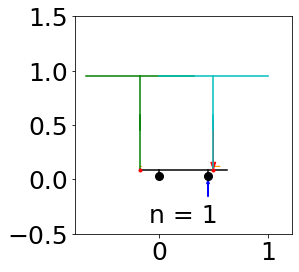

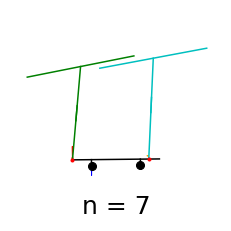

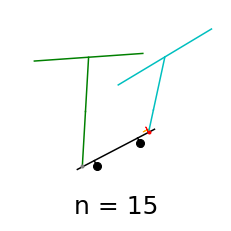

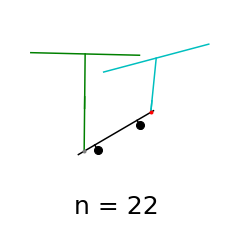

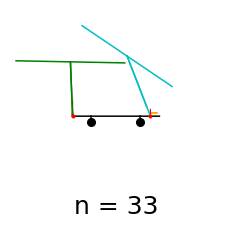

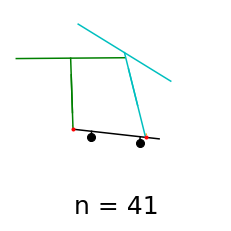

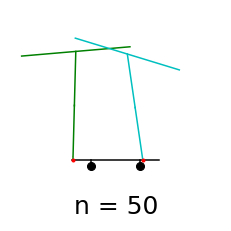

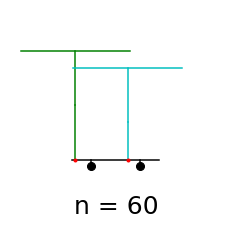

In [57]:
count = 1
Nplot = 1
Nplot_up = N
Nsplot = [1,7,15,22,33,41,50,60]
# for n in range(Nplot,Nplot_up,1):
for n in Nsplot:
    make_discrete_plots(m,n,count)
    fig_name = 'plots\\design_3\\design_3_' + str(n) + '.png'
    plt.savefig(fig_name, format='png',bbox_inches='tight')
#     plt.close()
    count +=1

In [41]:
# m.tau_a.pprint()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

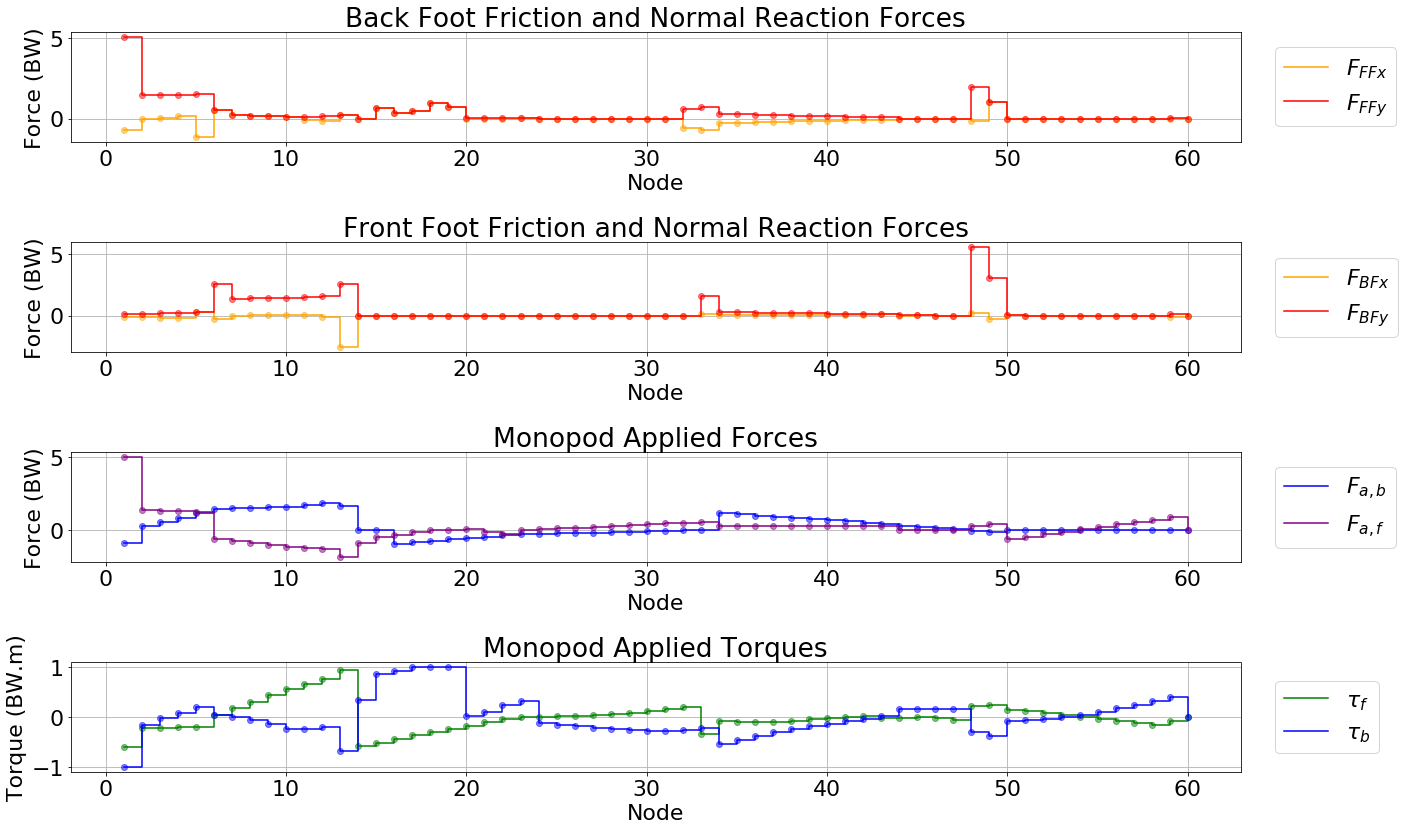

In [58]:
from matplotlib import colors as mcolors 

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Plot some of the variables
plt.rcParams.update({'font.size': 22}) # change font size

F_BFxar = [m.Fb_b_total[i,'BF','x_b']() for i in range(Nplot,Nplot_up+1)]
F_FFxar = [m.Fb_b_total[i,'FF','x_b']() for i in range(Nplot,Nplot_up+1)]
F_BFyar = [m.Fb_b_total[i,'BF','y_b']() for i in range(Nplot,Nplot_up+1)]
F_FFyar = [m.Fb_b_total[i,'FF','y_b']() for i in range(Nplot,Nplot_up+1)]
GRF_BWar = [m.GRF[i,'BW']() for i in range(Nplot,Nplot_up+1)]
GRF_FWar = [m.GRF[i,'FW']() for i in range(Nplot,Nplot_up+1)]
Fa_BF_ar = [m.F_a[i,'mono1']() for i in range(Nplot,Nplot_up+1)]
tau_BF_ar = [m.tau_a[i,'mono1']() for i in range(Nplot,Nplot_up+1)]
Fa_FF_ar = [m.F_a[i,'mono2']() for i in range(Nplot,Nplot_up+1)]
tau_FF_ar = [m.tau_a[i,'mono2']() for i in range(Nplot,Nplot_up+1)]

h_ar = h_ar1[Nplot-1:Nplot_up]

n_ar = np.linspace(1,N,N)

plt.figure(figsize=(20, 12))
plt.subplot(4,1,1)
plt.step(n_ar, F_FFxar,where='post',color = 'orange', label = r'$F_{FFx}$')
plt.plot(n_ar, F_FFxar, 'o', color='orange',alpha=0.5)
plt.step(n_ar, F_FFyar,where='post',color = 'red', label = r'$F_{FFy}$')
plt.plot(n_ar, F_FFyar, 'o', color='red',alpha=0.5)
plt.title('Back Foot Friction and Normal Reaction Forces')
plt.xlabel('Node')
plt.ylabel('Force (BW)')
plt.legend(bbox_to_anchor=(1.02,0.5), loc="center left")
plt.grid(True)

plt.subplot(4,1,2)
plt.step(n_ar, F_BFxar,where='post',color = 'orange', label=r'$F_{BFx}$')
plt.plot(n_ar, F_BFxar, 'o', color = 'orange', alpha=0.5)
plt.step(n_ar, F_BFyar,where='post',color = 'red', label=r'$F_{BFy}$')
plt.plot(n_ar, F_BFyar, 'o', color='red',alpha=0.5)
plt.title('Front Foot Friction and Normal Reaction Forces')
plt.xlabel('Node')
plt.ylabel('Force (BW)')
plt.legend(bbox_to_anchor=(1.02,0.5), loc="center left")
plt.grid(True)

plt.subplot(4,1,3)
plt.step(n_ar, Fa_BF_ar,where='post',color='blue',label = r'$F_{a,b}$')
plt.plot(n_ar, Fa_BF_ar, 'o', color='blue', alpha=0.5)
plt.step(n_ar, Fa_FF_ar,where='post',color='purple',label = r'$F_{a,f}$')
plt.plot(n_ar, Fa_FF_ar, 'o', color='purple', alpha=0.5)
plt.title('Monopod Applied Forces')
plt.xlabel('Node')
plt.ylabel('Force (BW)')
plt.legend(bbox_to_anchor=(1.02,0.5), loc="center left")
plt.grid(True)

plt.subplot(4,1,4)
plt.step(n_ar, tau_BF_ar, where='post',color='green',label = r'$\tau_{f}$')
plt.plot(n_ar, tau_BF_ar, 'o', color='green', alpha=0.5)
plt.step(n_ar, tau_FF_ar, where='post',color='blue',label = r'$\tau_{b}$')
plt.plot(n_ar, tau_FF_ar, 'o', color='blue', alpha=0.5)
plt.title('Monopod Applied Torques')
plt.xlabel('Node')
plt.ylabel('Torque (BW.m)')
plt.legend(bbox_to_anchor=(1.02,0.5), loc="center left")
plt.grid(True)

plt.tight_layout()

fig_name = 'plots\\design_3\\design_3_' + str(n) + '.eps'
plt.savefig(fig_name, format='eps')
fig_name = 'plots\\design_3\\design_3_' + str(n) + '.svg'
plt.savefig(fig_name, format='svg')

In [24]:
# m.pfoot_b.pprint()

In [25]:
from datetime import datetime

now = datetime.now() # dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M.pkl")

modelname = 'model_save_Neq60_2_monos_' + dt_string 
filepath = 'saved_models\\'
filename = filepath+modelname
print(filename)

with open(filename, mode='wb') as file:
    cloudpickle.dump(m, file)

saved_models\model_save_Neq60_2_monos_09_10_2019_21_56.pkl


In [26]:
# ANIMATE THE RESULTS
from IPython.display import HTML
%matplotlib inline

animate_realtime = skaterlib_2.make_realtime_animation(m, N, hm)
HTML(animate_realtime.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [27]:
# m.h.pprint()